In [23]:
#Import Libraries
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn-whitegrid')
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score, regressionSummary

In [24]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
features=pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [25]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [26]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [27]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


## Feature Engineering

In [28]:
# Change date column into datetime
features["Date"] = pd.to_datetime(features["Date"])
train["Date"] = pd.to_datetime(train["Date"])
test["Date"] = pd.to_datetime(test["Date"])

In [29]:
train_df=pd.merge(pd.merge(train,features,on=['Store','Date','IsHoliday'],how='left'),stores,on=['Store'], how='left')
test_df=pd.merge(pd.merge(test,features,on=['Store','Date', 'IsHoliday'],how='left'),stores,on=['Store'], how='left')

In [30]:
# Adding column to training data
train_df['Year'] = pd.to_datetime(train_df['Date']).dt.year
train_df['Month'] = pd.to_datetime(train_df['Date']).dt.month
train_df['Week'] = pd.to_datetime(train_df['Date']).dt.week

# Adding column to test data
test_df['Year'] = pd.to_datetime(test_df['Date']).dt.year
test_df['Month'] = pd.to_datetime(test_df['Date']).dt.month
test_df['Week'] = pd.to_datetime(test_df['Date']).dt.week

## Data cleaning and processing

In [31]:
train_df.shape

(421570, 19)

In [32]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     150681 non-null  float64       
 8   MarkDown2     111248 non-null  float64       
 9   MarkDown3     137091 non-null  float64       
 10  MarkDown4     134967 non-null  float64       
 11  MarkDown5     151432 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  Type          421570 non-null  object        
 15  Size          421

In [33]:
train_df.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
Year                 0
Month                0
Week                 0
dtype: int64

In [34]:
train_df_null_val = pd.concat([
    train_df.isnull().sum(axis = 0),
    (train_df.isnull().sum(axis = 0)/len(train_df))], axis=1)
train_df_null_val = train_df_null_val.rename(columns={0: 'No. of null values', 1: 'Percent of null values'})

train_df_null_val

,No. of null values,Percent of null values
Store,0,0.000000
Dept,0,0.000000
Date,0,0.000000
Weekly_Sales,0,0.000000
IsHoliday,0,0.000000
Temperature,0,0.000000
Fuel_Price,0,0.000000
MarkDown1,270889,0.642572
MarkDown2,310322,0.736110
MarkDown3,284479,0.674808


The features - Markdown 1 to 5 have more than 60% of null values. If the correlations of these features with the target variable 'WeeklySales' are very low, then we can think about to drop them. 

In [35]:
test_df.shape

(115064, 18)

In [36]:
test_df.isnull().sum()

Store               0
Dept                0
Date                0
IsHoliday           0
Temperature         0
Fuel_Price          0
MarkDown1         149
MarkDown2       28627
MarkDown3        9829
MarkDown4       12888
MarkDown5           0
CPI             38162
Unemployment    38162
Type                0
Size                0
Year                0
Month               0
Week                0
dtype: int64

In [37]:
test_df['CPI'] = test_df.groupby(['Dept'])['CPI'].transform(lambda x:x.fillna(x.mean())) 
test_df['Unemployment'] = test_df.groupby(['Dept'])['Unemployment'].transform(lambda x:x.fillna(x.mean()))

In [38]:
# label encode of column - IsHoliday 
train_df['IsHoliday'] = train_df['IsHoliday'].apply(lambda x: 1 if x == True else 0)
test_df['IsHoliday'] = test_df['IsHoliday'].apply(lambda x: 1 if x == True else 0)

# label encode of column - Type 
train_df['Type'] = train_df['Type'] .apply(lambda x: 3 if x == 'A' else(2 if x == 'B' else 1))
test_df['Type'] = test_df['Type'].apply(lambda x: 3 if x == 'A' else(2 if x == 'B' else 1))

In [39]:
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

## Exploratory Data Analysis based on the features

In [40]:
# Overview of  training data
train_df.describe()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Year,Month,Week
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,0.070358,60.090059,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289,2.410088,136727.915739,2010.968591,6.449510,25.826762
std,12.785297,30.492054,22711.183519,0.255750,18.447931,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296,0.666337,60980.583328,0.796876,3.243217,14.151887
min,1.000000,1.000000,-4988.940000,0.000000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,1.000000,34875.000000,2010.000000,1.000000,1.000000
25%,11.000000,18.000000,2079.650000,0.000000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,2.000000,93638.000000,2010.000000,4.000000,14.000000
50%,22.000000,37.000000,7612.030000,0.000000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000,3.000000,140167.000000,2011.000000,6.000000,26.000000
75%,33.000000,74.000000,20205.852500,0.000000,74.280000,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000,3.000000,202505.000000,2012.000000,9.000000,38.000000
max,45.000000,99.000000,693099.360000,1.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,3.000000,219622.000000,2012.000000,12.000000,52.000000


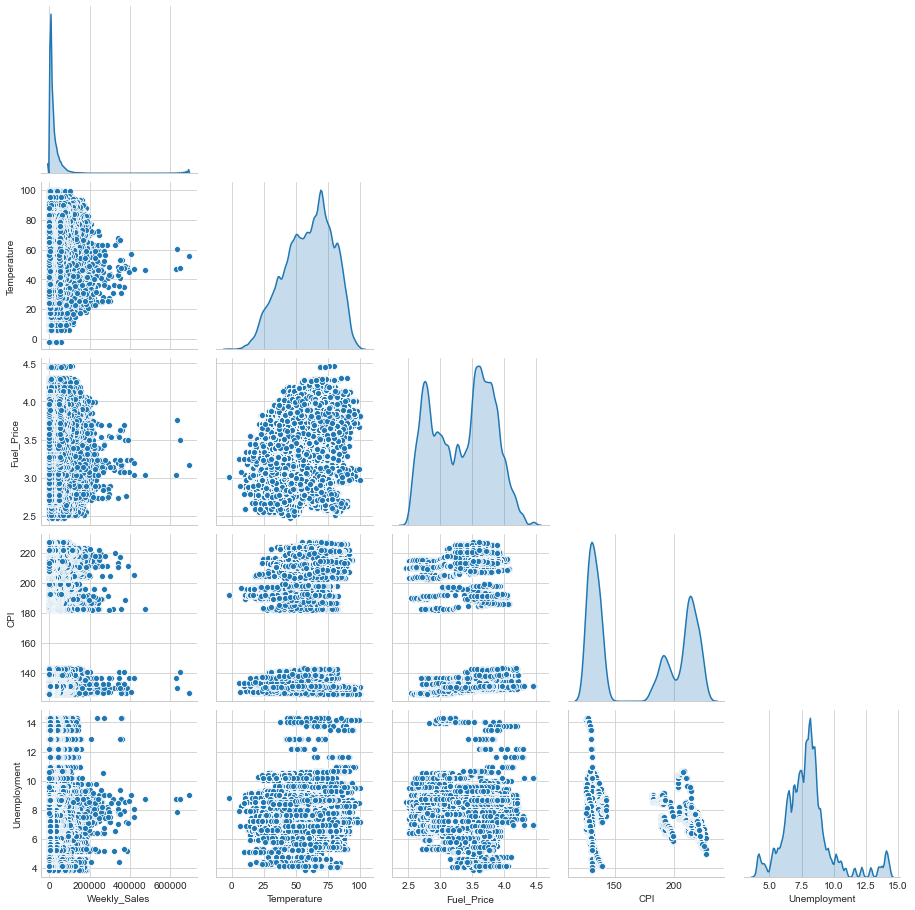

In [41]:
sns.pairplot(train_df[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']],
             corner=True,diag_kind="kde")
plt.show()

From above graph, we can see that variables - Temperature, Fuel_Price, Unemployment, CPI all are skewed data  with respect to weekly sales and they does not display any particular relationship between weekly sales.

Also, distribution of target variable is highly skewed. That's why, I will not go with linear regression.

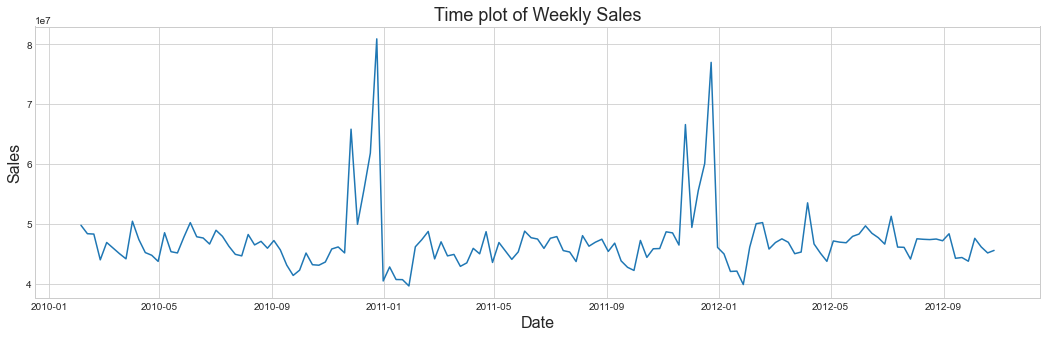

In [44]:
# Weekly sales plot
df_average_sales_weekly = train_df.groupby(by=["Date"], as_index = False)["Weekly_Sales"].sum()
df_average_sales = df_average_sales_weekly.sort_values("Weekly_Sales", ascending=False)

plt.figure(figsize=(18,5))
plt.plot(df_average_sales_weekly.Date, df_average_sales_weekly.Weekly_Sales)
plt.title('Time plot of Weekly Sales', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.show()


#### General comments about the graph

Trend - no strong evidence of major trend on data
Seasonality - Strong seasonality in the training dataset, where the end of year seems like a popular time to buy our company's specific products. The theory is that this has to do with the holidays and people buy gifts for each other, which seems reasonable.
Random or Irregular movements - no major random events in datasets

Plotting the average sales on our dataset, we can see:

#### Use same chart, to show mean and median of the weekly sales :

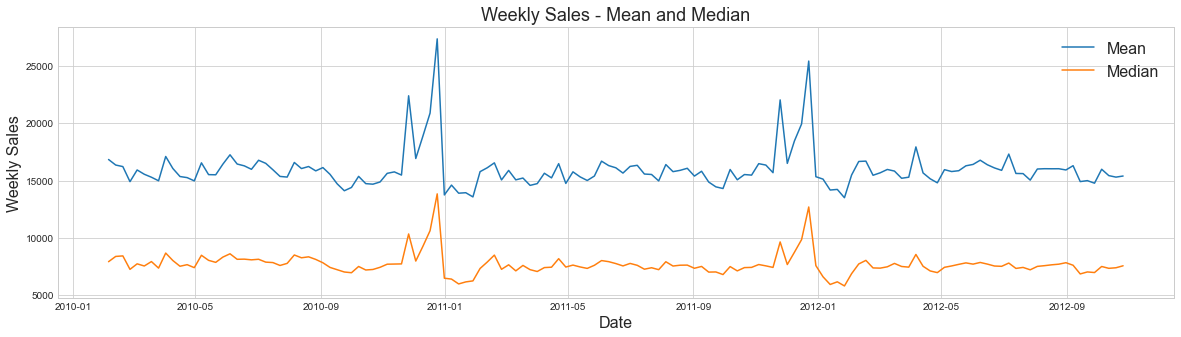

In [46]:
weekly_sales_mean = train_df['Weekly_Sales'].groupby(train_df['Date']).mean()
weekly_sales_median = train_df['Weekly_Sales'].groupby(train_df['Date']).median()
plt.figure(figsize=(20,5))
sns.lineplot(weekly_sales_mean.index, weekly_sales_mean.values)
sns.lineplot(weekly_sales_median.index, weekly_sales_median.values)

plt.legend(['Mean', 'Median'], loc='best', fontsize=16)
plt.title('Weekly Sales - Mean and Median', fontsize=18)
plt.ylabel('Weekly Sales', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.show()

We can notice that the mean and the median in above plot are very different, implementing that some stores/departments might sell much more than others.

#### Plot Average weekly Sales per Store 

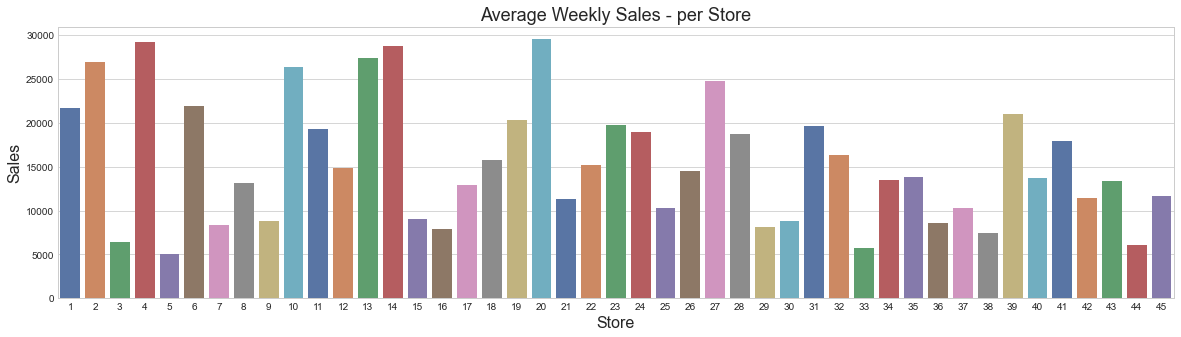

In [107]:
weekly_sales = train_df['Weekly_Sales'].groupby(train_df['Store']).mean()
plt.figure(figsize=(20,5))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='deep')

plt.title('Average Weekly Sales - per Store', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()

We can notice that there are Sales difference between 45 Stores of Walmart

#### Plot Average weekly Sales per Department

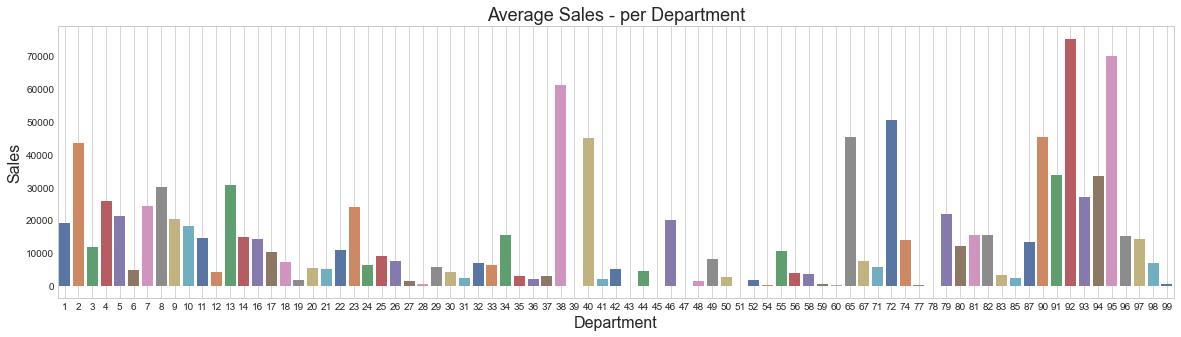

In [108]:
weekly_sales = train_df['Weekly_Sales'].groupby(train_df['Dept']).mean()
plt.figure(figsize=(20,5))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='deep')
plt.grid()
plt.title('Average Sales - per Department', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Department', fontsize=16)
plt.show()

We can notice the Sales difference between the Departments also. Also some Departments are not in the training dataset.

##### Feature Correlation
Let's see the correlation between variables, using Pearson Correlation.
Positive Correlation indicates that when one variable increase, the other also does. Negative is the opposite

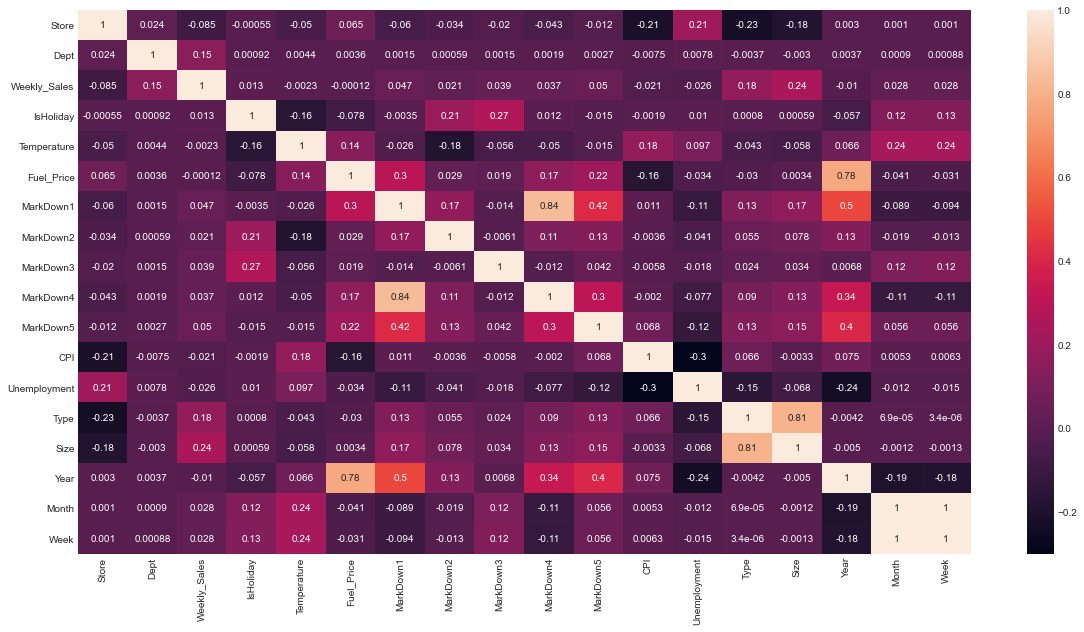

In [109]:
# Correlation between all features
plt.figure(figsize=(20,10))
sns.heatmap(train_df.corr(),annot=True)
plt.show()

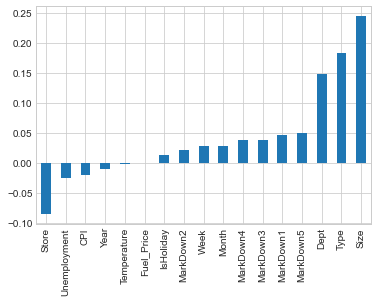

In [110]:
# Plotting bar graph for correlation values  
train_df.corr()['Weekly_Sales'].sort_values()[:-1].plot.bar()
plt.show()

According to above the correlation matrix by heatmap and barplot, we have below observations:

1.MarkDown1 is strongly correlated to MarkDown4. One of can must be dropped else they would carry similar information to the model.

2.Fuel_Price is strong correlated to Year. One of them can be dropped else they would carry similar information. 'Year' will not be dropped, because it differentiate same Weeks for Store/Department.

3.Features - Temperature, Fuel_Price, Unemployment, CPI have very lower correlation with Sales as well as they are skewed too. So, we can dropped them.

In [111]:
train_df.drop(['Temperature', 'Fuel_Price', 'Unemployment', 'CPI','Month'], axis=1, inplace=True)
train_df.drop(['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5'], axis=1, inplace=True)

test_df.drop(['Temperature', 'Fuel_Price', 'Unemployment', 'CPI','Month'], axis=1, inplace=True)
test_df.drop(['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5'], axis=1, inplace=True)

#### Analyzing Variables

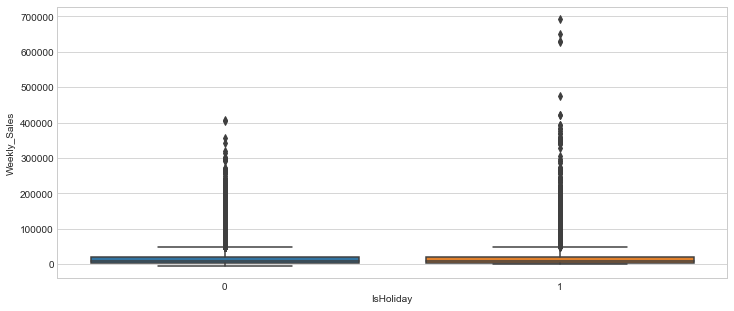

In [112]:
plt.figure(figsize=(12,5))
sns.boxplot(y=train_df['Weekly_Sales'],x=train_df['IsHoliday'])
plt.show()

We can see that its obvoius that Holidays weeks have more high sales than non-Holiday weeks.

In [129]:
def WMAE(dataset, real, predicted):
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)

## Create Train & Test Data

In [116]:
# DF x & y

train_X = train_df.drop(["Weekly_Sales","Date"], axis=1)
train_y = train_df["Weekly_Sales"]
#test_X = test_df # making the syntax shorter --> Sub = submission
test_df = test_df.drop(["Date"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2)

In [130]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 337256 entries, 135328 to 33051
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   Store      337256 non-null  int64
 1   Dept       337256 non-null  int64
 2   IsHoliday  337256 non-null  int64
 3   Type       337256 non-null  int64
 4   Size       337256 non-null  int64
 5   Year       337256 non-null  int64
 6   Week       337256 non-null  int64
dtypes: int64(7)
memory usage: 20.6 MB


In [131]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   Store      115064 non-null  int64
 1   Dept       115064 non-null  int64
 2   IsHoliday  115064 non-null  int64
 3   Type       115064 non-null  int64
 4   Size       115064 non-null  int64
 5   Year       115064 non-null  int64
 6   Week       115064 non-null  int64
dtypes: int64(7)
memory usage: 7.0 MB


### Multilinear Regression

In [89]:
model = LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test) 

# print coefficients
print('intercept ',model.intercept_)
print(pd.DataFrame({'Predictor': X_train.columns, 'coefficient': model.coef_}))
print("\n")

# print performance measures
#regressionSummary(y_train, model.predict(X_train))
#regressionSummary(y_test, model.predict(X_test))
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred)) #MAE
print("MSE: ", metrics.mean_squared_error(y_test, y_pred)) #MSE
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #RMSE

score = r2_score(y_test, model.predict(X_test))
print("R^2:", score)

intercept  893925.9369872287
    Predictor  coefficient
0       Store   -88.500251
1        Dept   111.054840
2   IsHoliday   164.784019
3   MarkDown2    -0.000979
4   MarkDown3     0.099833
5   MarkDown4     0.048467
6   MarkDown5     0.087968
7        Type -1899.563256
8        Size     0.103068
9        Year  -443.357559
10       Week    35.730852


MAE:  14575.551573502125
MSE:  468961188.0118861
RMSE:  21655.511723620988
R^2: 0.08652918623610273


In [90]:
#backward elimination
def train_model(variables):
    model = LinearRegression()
    model.fit(X_train[variables],y_train)
    return model

def score_model(model, variables):
    return AIC_score(y_train, model.predict(X_train[variables]), model)

best_model, best_variables = backward_elimination(X_train.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: Store, Dept, IsHoliday, MarkDown2, MarkDown3, MarkDown4, MarkDown5, Type, Size, Year, Week
Start: score=7692797.18
Step: score=7692795.20, remove MarkDown2
Step: score=7692794.29, remove IsHoliday
Step: score=7692794.29, remove None
['Store', 'Dept', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'Type', 'Size', 'Year', 'Week']


In [91]:
regressionSummary(y_test, best_model.predict(X_test[best_variables]))


Regression statistics

               Mean Error (ME) : -51.8121
Root Mean Squared Error (RMSE) : 21655.6344
     Mean Absolute Error (MAE) : 14575.6692


In [92]:
best_pred=best_model.predict(X_test[best_variables])
print('adjusted r2 : ', adjusted_r2_score(y_test, best_pred, best_model))

adjusted r2 :  0.08642131401920738


### KNN Regressor

In [96]:
knn = KNeighborsRegressor(n_neighbors = 5).fit(X_train, y_train) 

y_pred = knn.predict(X_test)

In [97]:
from sklearn import metrics

# Print out the MAE, MSE & RMSE
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred)) #MAE
print("MSE: ", metrics.mean_squared_error(y_test, y_pred)) #MSE
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #RMSE

# rSquared
score = r2_score(y_test, y_pred)
print("R^2:", score)

MAE:  8679.996038949641
MSE:  239904950.14999473
RMSE:  15488.865360315931
R^2: 0.5298591299499751


### Decision Tree 

In [98]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

In [100]:
# Print out the MAE, MSE & RMSE
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred)) #MAE
print("MSE: ", metrics.mean_squared_error(y_test, y_pred)) #MSE
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #RMSE

# rSquared
score = r2_score(y_test, y_pred)
print("R^2:", score)

MAE:  1746.5329598880373
MSE:  18048048.054556824
RMSE:  4248.299430896653
R^2: 0.9646313049823737


### Random Forest Regressor

In [119]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [121]:
# Print out the MAE, MSE & RMSE
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred)) #MAE
print("MSE: ", metrics.mean_squared_error(y_test, y_pred)) #MSE
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #RMSE

# rSquared
score = r2_score(y_test, y_pred)
print("R^2:", score)

MAE:  1328.0118279633273
MSE:  10823641.395054637
RMSE:  3289.9303024615333
R^2: 0.9787541333869174


In [50]:
#Initial guess for parameters
param_grid = {
'max_depth':[10,30,50],
'min_impurity_decrease':[0,0.001, 0.005],
'min_samples_split':[2,4,6],
'n_estimators': [20,100,150],
'max_features' : [6,9,12]
}

In [52]:
rf=RandomForestRegressor()
rf_randomcv=RandomizedSearchCV(estimator=rf,param_distributions=param_grid,n_iter=100,cv=3,verbose=2,
                               n_jobs=-1)
### fit the randomized model
rf_randomcv.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 35.6min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 30, 50],
                                        'max_features': [6, 9, 12],
                                        'min_impurity_decrease': [0, 0.001,
                                                                  0.005],
                                        'min_samples_split': [2, 4, 6],
                                        'n_estimators': [20, 100, 150]},
                   verbose=2)

In [40]:
rf_randomcv.best_params_

NameError: name 'rf_randomcv' is not defined

In [41]:
rf_randomcv

NameError: name 'rf_randomcv' is not defined

In [59]:
best_random_grid=rf_randomcv.best_estimator_

In [39]:
y_pred=best_random_grid.predict(X_test)
# Print out the MAE, MSE & RMSE
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred)) #MAE
print("MSE: ", metrics.mean_squared_error(y_test, y_pred)) #MSE
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #RMSE

# rSquared
score = r2_score(y_test, y_pred)
print("R^2:", score)

NameError: name 'best_random_grid' is not defined

In [125]:
RF1 = RandomForestRegressor(n_estimators=58, max_depth=27, max_features=6, min_samples_split=3, min_samples_leaf=1)
RF1.fit(X_train, y_train)

RandomForestRegressor(max_depth=27, max_features=6, min_samples_split=3,
                      n_estimators=58)

#### The final model we will using is Random Forest Model

In [126]:
#test_X = test_df[['Store', 'Dept', 'IsHoliday','Size', 'Week', 'Type', 'Year']]
final_predict = RF1.predict(test_df)

In [127]:
final_predict

array([31882.37720402, 19564.54280747, 19209.76511494, ...,
         715.15710057,   770.14852586,   695.39458333])

In [128]:
submission = pd.read_csv('sampleSubmission.csv')
submission['Weekly_Sales'] = final_predict
submission.to_csv('final_result.csv',index=False)
submission

,Id,Weekly_Sales
0,1_1_2012-11-02,31882.377204
1,1_1_2012-11-09,19564.542807
2,1_1_2012-11-16,19209.765115
3,1_1_2012-11-23,20430.609115
4,1_1_2012-11-30,27192.098925
...,...,...
115059,45_98_2013-06-28,738.289629
115060,45_98_2013-07-05,721.721066
115061,45_98_2013-07-12,715.157101
115062,45_98_2013-07-19,770.148526
